<a href="https://colab.research.google.com/github/Daryldactyl/Training_Transformers/blob/main/Translation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an English to Spanish Translation Model
### Import the Dataset
For possible languages to use with this dataset go to https://opus.nlpl.eu/results/en&es-MX/corpus-result-table

In [1]:
#!pip install transformers datasets sentencepiece

In [2]:
from datasets import load_dataset
data = load_dataset('kde4', lang1='en', lang2='es')
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 218655
    })
})

We have 218 thousand rows of data which will be too big for our free colab instance

#### Shrink the Dataset for faster processing

In [3]:
small = data['train'].shuffle(seed=42).select(range(1_000))
split = small.train_test_split(seed=42)
split['train'][0]

{'id': '74222',
 'translation': {'en': 'Mute command turns the sound on or off.',
  'es': 'La orden Silenciar activa o desactiva el sonido.'}}

In [4]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 250
    })
})

### Tokenize the Input and the Translation

In [5]:
from transformers import AutoTokenizer

checkpoint = 'Helsinki-NLP/opus-mt-en-es'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
en = split['train'][1]['translation']['en']
es = split['train'][1]['translation']['es']
en, es

('Remove the current bookmark. This command is only available if the cursor is at a bookmarked location.',
 'Borra el marcador actual. Este comando se encuentra disponible si el cursor está en una ubicación marcada.')

In [7]:
inputs = tokenizer(en)
inputs

{'input_ids': [23292, 5, 1149, 2316, 8407, 3, 143, 6745, 31, 211, 627, 174, 5, 46861, 31, 73, 8, 2316, 8407, 118, 1103, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
targets = tokenizer(text_target=es)
targets

{'input_ids': [8002, 514, 14, 37527, 1029, 3, 539, 21734, 26, 1607, 2971, 122, 14, 2134, 91, 108, 12, 38, 2288, 20488, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])

['▁Bor',
 'ra',
 '▁el',
 '▁marcador',
 '▁actual',
 '.',
 '▁Este',
 '▁comando',
 '▁se',
 '▁encuentra',
 '▁disponible',
 '▁si',
 '▁el',
 '▁curso',
 'r',
 '▁está',
 '▁en',
 '▁una',
 '▁ubicación',
 '▁marcada',
 '.',
 '</s>']

In [10]:
#What if we use the tokenizer incorrectly (for example english tokenizer on spanish sentence)
bad_targets = tokenizer(es)
tokenizer.convert_ids_to_tokens(bad_targets['input_ids'])

['▁Bor',
 'ra',
 '▁el',
 '▁mar',
 'c',
 'ador',
 '▁actual',
 '.',
 '▁Este',
 '▁com',
 'ando',
 '▁se',
 '▁en',
 'cu',
 'en',
 'tra',
 '▁dis',
 'pon',
 'ible',
 '▁si',
 '▁el',
 '▁cursor',
 '▁est',
 'á',
 '▁en',
 '▁una',
 '▁u',
 'bic',
 'aci',
 'ó',
 'n',
 '▁mar',
 'c',
 'ada',
 '.',
 '</s>']

Instead of UNK tokens this tokenizer appears to be working on BPE or Byte Pair Encoding to catch unfamiliar tokens

### Get Sequence Length of Inputs and Targets to establish what the max will be so we can set the max length to best fit most of the data

(array([339., 178.,  72.,  42.,  24.,  12.,  12.,   4.,   7.,  10.,   3.,
          7.,   5.,   1.,   3.,   1.,   4.,   2.,   3.,   5.,   2.,   2.,
          1.,   1.,   1.,   0.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,  15.72,  30.44,  45.16,  59.88,  74.6 ,  89.32, 104.04,
        118.76, 133.48, 148.2 , 162.92, 177.64, 192.36, 207.08, 221.8 ,
        236.52, 251.24, 265.96, 280.68, 295.4 , 310.12, 324.84, 339.56,
        354.28, 369.  , 383.72, 398.44, 413.16, 427.88, 442.6 , 457.32,
        472.04, 486.76, 501.48, 516.2 , 530.92, 545.64, 560.36, 575.08,
        589.8 , 604.52, 619.24, 633.96, 648.68, 663.4 , 678.12, 692.84,
        707.56, 722.28, 737.  ]),
 <BarContainer object of 50 artists>)

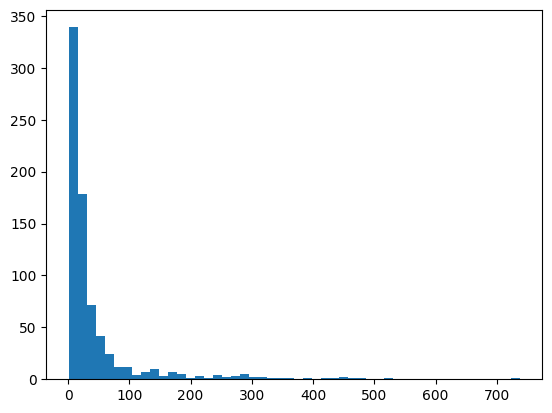

In [11]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50)

(array([251., 227.,  92.,  53.,  25.,  21.,   9.,   5.,  11.,   4.,   6.,
          8.,   2.,   3.,   3.,   2.,   4.,   2.,   3.,   2.,   4.,   1.,
          0.,   0.,   1.,   1.,   3.,   3.,   0.,   0.,   0.,   0.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,  18.12,  35.24,  52.36,  69.48,  86.6 , 103.72, 120.84,
        137.96, 155.08, 172.2 , 189.32, 206.44, 223.56, 240.68, 257.8 ,
        274.92, 292.04, 309.16, 326.28, 343.4 , 360.52, 377.64, 394.76,
        411.88, 429.  , 446.12, 463.24, 480.36, 497.48, 514.6 , 531.72,
        548.84, 565.96, 583.08, 600.2 , 617.32, 634.44, 651.56, 668.68,
        685.8 , 702.92, 720.04, 737.16, 754.28, 771.4 , 788.52, 805.64,
        822.76, 839.88, 857.  ]),
 <BarContainer object of 50 artists>)

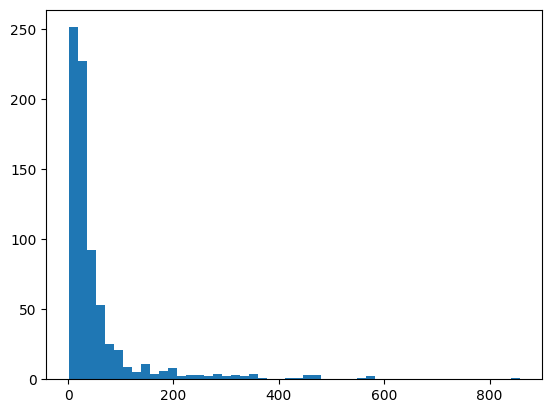

In [12]:
target_lens = [len(tr['es']) for tr in train]
plt.hist(target_lens, bins=50)

### Using this Info Let's build the Tokenizer Function for the entire dataset

In [13]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
  inputs = [x['en'] for x in batch['translation']]
  targets = [x['es'] for x in batch['translation']]

  tokenized_inputs = tokenizer(
      inputs, max_length=max_input_len, truncation=True
  )

  tokenized_targets = tokenizer(text_target=targets, max_length=max_target_len, truncation=True)

  tokenized_inputs['labels'] = tokenized_targets['input_ids']
  return tokenized_inputs

In [14]:
tokenized_datasets = split.map(
    tokenizer_fn, batched=True, remove_columns=split['train'].column_names
)

In [15]:
print(f"English: {tokenizer.convert_ids_to_tokens(tokenized_datasets['train']['input_ids'][0])}\nSpanish: {tokenizer.convert_ids_to_tokens(tokenized_datasets['train']['labels'][0])}")

English: ['▁Mu', 'te', '▁command', '▁turns', '▁the', '▁sound', '▁on', '▁or', '▁off', '.', '</s>']
Spanish: ['▁La', '▁orden', '▁Sil', 'encia', 'r', '▁activa', '▁o', '▁de', 's', 'activa', '▁el', '▁sonido', '.', '</s>']


### Load the Model

In [16]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(65001, 512, padding_idx=65000)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(65001, 512, padding_idx=65000)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

### Use Data Collator to manage the padding

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [18]:
print([tokenized_datasets['train'][i] for i in range(2)])

[{'input_ids': [3598, 203, 6745, 9457, 5, 3111, 35, 62, 843, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [69, 1491, 17737, 4718, 91, 4434, 60, 4, 9, 12233, 14, 7570, 3, 0]}, {'input_ids': [23292, 5, 1149, 2316, 8407, 3, 143, 6745, 31, 211, 627, 174, 5, 46861, 31, 73, 8, 2316, 8407, 118, 1103, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [8002, 514, 14, 37527, 1029, 3, 539, 21734, 26, 1607, 2971, 122, 14, 2134, 91, 108, 12, 38, 2288, 20488, 3, 0]}]


#### To get an Idea of whats happening, especially when it comes to the decoder lets compare the labels(targets) to the decoder input

We see that the decoder inputs are a shifted version of the targets. Thats because the decoder will take the encoded inputs and the decoder input then predict the next token. So "Considering this english sentence, and these characters from the decoder input, what is the next token?"

In [22]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [20]:
import numpy as np
for batch in batch['labels']:
  sentence = tokenizer.convert_ids_to_tokens(np.array(batch))
  print(sentence)

['▁Bor', 'ra', '▁el', '▁marcador', '▁actual', '.', '▁Este', '▁comando', '▁se', '▁encuentra', '▁disponible', '▁si', '▁el', '▁curso', 'r', '▁está', '▁en', '▁una', '▁ubicación', '▁marcada', '.', '</s>']
['▁Error', '▁al', '▁construir', '▁el', '▁paquete', '</s>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [23]:
for batch in batch['decoder_input_ids']:
  sentence = tokenizer.convert_ids_to_tokens(np.array(batch))
  print(sentence)

['<pad>', '▁Bor', 'ra', '▁el', '▁marcador', '▁actual', '.', '▁Este', '▁comando', '▁se', '▁encuentra', '▁disponible', '▁si', '▁el', '▁curso', 'r', '▁está', '▁en', '▁una', '▁ubicación', '▁marcada', '.']
['<pad>', '▁Error', '▁al', '▁construir', '▁el', '▁paquete', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


### Create the Compute functions

Imagine our translation is: The cat chased the mouse
But we predict: The cat ran after the mouse

We would like to count this as a successful translation but the words aren't the same. Thats where our different scores come in:
- **Bleu Score:** computes the n-grams and comes up with a score from 0-100 to the target (the higher the score, the worse the prediction)
```python
bleu_metric = load_metric("sacrebleu")
bleu_metric.compute(
  predictions=["The cat ran after the mouse"],
  references=[["The cat chased the mouse"]])
```

- **BERT Score:** This method will create an embedding for both the prediction and the target then calculate cosine similarity between the 2 (Using a pretrained BERT model). There is a threshold that if the 2 phrases are close enough it will count as correct.
```python
bert_metric = load_metric('bertscore')
bert_metric.compute(
  predictions=['The cat ran after the mouse'],
  references=[['The cat chased the mouse']],
  lang='en')
```

#### Bleu Score

In [24]:
#!pip install sacrebleu

Test on approximate match

In [25]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bleu_metric.compute(
  predictions=["The cat ran after the mouse"],
  references=[["The cat chased the mouse"]])

<ipython-input-25-c35661148265>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


{'score': 22.957488466614336,
 'counts': [4, 2, 0, 0],
 'totals': [6, 5, 4, 3],
 'precisions': [66.66666666666667, 40.0, 12.5, 8.333333333333334],
 'bp': 1.0,
 'sys_len': 6,
 'ref_len': 5}

Test on Perfect Match

In [26]:
bleu_metric.compute(
    predictions=['I love cats'],
    references=[['I love cats']]
)

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

#### BERT Score

In [27]:
#!pip install bert-score

Test on approximate match

In [28]:
bert_metric = load_metric('bertscore')

In [29]:
bert_metric.compute(
predictions=['The cat ran after the mouse'],
references=[['The cat chased the mouse']],
lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9700444936752319],
 'recall': [0.9870928525924683],
 'f1': [0.9784944653511047],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.2)'}

Test on Perfect Match

In [30]:
bert_metric.compute(
    predictions=['I love cats'],
    references=[['I love cats']],
    lang='en'
)

{'precision': [0.9999998807907104],
 'recall': [0.9999998807907104],
 'f1': [0.9999998807907104],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.41.2)'}

### Create the Compute Metrics Function

In [31]:
def compute_metrics(preds_and_labels):
  preds, labels = preds_and_labels

  #convert the predictions into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

  #for the unk (-100) tokens, change to pad tokens which matches the target
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  #convert labels into words
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  #Put targets into lists and get rid of whitespace
  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions = decoded_preds, references=decoded_labels)

  bert_score = bert_metric.compute(
      predictions=decoded_preds, references=decoded_labels, lang='es')

  return {'bleu': bleu['score'], 'bert_score': np.mean(bert_score['f1'])}

### Setup Training Arguments and the Trainer

In [32]:
#!pip install accelerate -U

In [33]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir='finetuned-model',
    evaluation_strategy='no', #To save compute time during evaluation
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    predict_with_generate=True,
    #fp16 = True #If using GPU
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    data_collator = data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#### Since we turned eval strategy to 'no' lets look at the evaluate before and after training

Before:

In [35]:
trainer.evaluate(max_length=max_target_len)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'eval_loss': 1.2224326133728027,
 'eval_bleu': 46.04053065831885,
 'eval_bert_score': 0.8938573379516601,
 'eval_runtime': 507.1002,
 'eval_samples_per_second': 0.493,
 'eval_steps_per_second': 0.016}

In [36]:
trainer.train()

Step,Training Loss


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


TrainOutput(global_step=47, training_loss=1.3437257320322888, metrics={'train_runtime': 451.0491, 'train_samples_per_second': 1.663, 'train_steps_per_second': 0.104, 'total_flos': 10247369785344.0, 'train_loss': 1.3437257320322888, 'epoch': 1.0})

After:

In [38]:
trainer.evaluate(max_length=max_target_len)

{'eval_loss': 1.1174921989440918,
 'eval_bleu': 47.80313508195514,
 'eval_bert_score': 0.8954301242828369,
 'eval_runtime': 465.2653,
 'eval_samples_per_second': 0.537,
 'eval_steps_per_second': 0.017,
 'epoch': 1.0}

We do see a small improvement, to further improve the model run on more epochs

In [37]:
trainer.save_model('my_saved_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


### Load the Trained Model and Test

In [39]:
from transformers import pipeline

translator = pipeline('translation', model='my_saved_model')

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [40]:
translator('I hope that this model is doing everything that we need and getting proper translations')

[{'translation_text': 'Espero que este modelo esté haciendo todo lo que necesitamos y obteniendo traducciones adecuadas.'}]

In [41]:
translator('Hello, how are you?')

[{'translation_text': 'Hola, ¿cómo estás?'}]